In [1]:
from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
torch.cuda.empty_cache()

In [3]:
fresh_start = True

In [4]:
# Root directory for dataset
dataroot = "data/dogs"

# Directory for checkpointing model and parameters state
checkpointsroot = "checkpoints/dogs2"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.

ngpu = 1

In [ ]:
print(torch.cuda.is_available())
print(torch.version.cuda)

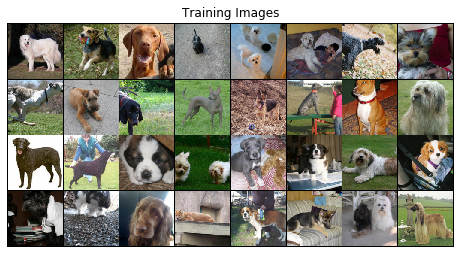

In [5]:
# We can use an image folder dataset the way we have it set up.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                          transform=transforms.Compose([
                              transforms.Resize(image_size),
                              transforms.CenterCrop(image_size),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                          ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1,2,0)))

In [ ]:
print(device)

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf * 2) x 32 x 32
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )

    def forward(self, input):
        return self.main(input)
    
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Add white noise to stabilize learning
            #nn.WhiteNoise(0,0.1),
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [7]:
def load_checkpoint(netG, netD, loss, fixed_noise, optimizerG, optimizerD, G_losses, D_losses, iters, filename):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    iters = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        netG.load_state_dict(checkpoint['netG_state_dict'])
        netD.load_state_dict(checkpoint['netD_state_dict'])
        criterion = checkpoint['criterion']
        fixed_noise = checkpoint['fixed_noise']
        optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
        optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])
        G_losses = checkpoint['G_losses']
        D_losses = checkpoint['D_losses']
        iters = checkpoint['iters']
        
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return start_epoch, netG, netD, criterion, fixed_noise, optimizerG, optimizerD, G_losses, D_losses, iters

In [8]:
# Start epoch
start_epoch = 0

# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
#print(netG)

# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
#print(netD)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

G_losses = []
D_losses = []
iters = 0

if not fresh_start:
    start_epoch, netG, netD, criterion, fixed_noise, optimizerG, optimizerD, G_losses, D_losses, iters = load_checkpoint(netG, netD, criterion, fixed_noise, optimizerG, optimizerD, G_losses, D_losses, iters, checkpointsroot+'/state_39.pth')
    netG.to(device)
    netD.cuda(device)
    
    # now individually transfer the optimizer parts...
    for state in optimizerG.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)

    # now individually transfer the optimizer parts...
    for state in optimizerD.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)


# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

In [9]:
# Training Loop

total_epochs = start_epoch + num_epochs

# Lists to keep track of progress
img_list = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(start_epoch, total_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, total_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    
    state = {
            'epoch': epoch + 1,
            'netG_state_dict': netG.state_dict(),
            'netD_state_dict': netD.state_dict(),
            'criterion': criterion,
            'fixed_noise': fixed_noise,
            'optimizerG_state_dict': optimizerG.state_dict(),
            'optimizerD_state_dict': optimizerD.state_dict(),
            'G_losses': G_losses,
            'D_losses': D_losses,
            'iters': iters
            }
    torch.save(state, '%s/state_%d.pth' % (checkpointsroot, epoch))

Starting Training Loop...


C:\Users\nathan\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\loss.py:498: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([512])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


ValueError: Target and input must have the same number of elements. target nelement (32) != input nelement (512)

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

## VAE

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms


def to_var(x):
    """ Make a tensor cuda-erized and requires gradient """
    return to_cuda(x).requires_grad_()

def to_cuda(x):
    """ Cuda-erize a tensor """
    if torch.cuda.is_available():
        x = x.cuda()
    return x

def get_data(BATCH_SIZE=100):
    """ Load data for binared MNIST """
    torch.manual_seed(3435)
    
    # We can use an image folder dataset the way we have it set up.
    # Create the dataset
    dataset = dset.ImageFolder(root=dataroot,
                              transform=transforms.Compose([
                                  transforms.Resize(image_size),
                                  transforms.CenterCrop(image_size),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                              ]))

    # Create the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=workers)

    # Decide which device we want to run on
    device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
    
    # Plot some training images
    real_batch = next(iter(dataloader))
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1,2,0)))

    return dataloader

In [ ]:
""" (VAE) https://arxiv.org/abs/1312.6114
Variational Autoencoder
From the abstract:
"We introduce a stochastic variational inference and learning algorithm that
scales to large datasets and, under some mild differentiability conditions,
even works in the intractable case. Our contributions is two-fold. First, we
show that a reparameterization of the variational lower bound yields a lower
bound estimator that can be straightforwardly optimized using standard
stochastic gradient methods. Second, we show that for i.i.d. datasets with
continuous latent variables per datapoint, posterior inference can be made
especially efficient by fitting an approximate inference model (also called a
recognition model) to the intractable posterior using the proposed lower bound
estimator."
Basically VAEs encode an input into a given dimension z, reparametrize that z
using it's mean and std, and then reconstruct the image from reparametrized z.
This lets us tractably model latent representations that we may not be
explicitly aware of that are in the data. For a simple example of what this may
look like, read up on "Karl Pearson's Crabs." The basic idea was that a
scientist collected data on a population of crabs, noticed that the distribution
was non-normal, and Pearson postulated it was because there were likely more
than one population of crabs studied. This would've been a latent variable,
since the data colllector did not initially know or perhaps even suspect this.
"""

import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

import os
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from tqdm import tqdm
from itertools import product

class Encoder(nn.Module):
    """ MLP encoder for VAE. Input is an image,
    outputs are the mean, std of the latent variable z pre-reparametrization
    """
    def __init__(self, image_size, hidden_dim, z_dim):
        super().__init__()

        self.linear = nn.Linear(image_size, hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.log_var = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        activated = F.relu(self.linear(x))
        mu, log_var = self.mu(activated), self.log_var(activated)
        return mu, log_var


class Decoder(nn.Module):
    """ MLP decoder for VAE. Input is a reparametrized latent representation,
    output is reconstructed image
    """
    def __init__(self, z_dim, hidden_dim, image_size):
        super().__init__()

        self.linear = nn.Linear(z_dim, hidden_dim)
        self.recon = nn.Linear(hidden_dim, image_size)

    def forward(self, z):
        activated = F.relu(self.linear(z))
        reconstructed = torch.sigmoid(self.recon(activated))
        return reconstructed


class VAE(nn.Module):
    """ VAE super class to reconstruct an image. Contains reparametrization
    method for latent variable z
    """
    def __init__(self, image_size=784, hidden_dim=400, z_dim=20):
        super().__init__()

        self.__dict__.update(locals())

        self.encoder = Encoder(image_size=image_size, hidden_dim=hidden_dim, z_dim=z_dim)
        self.decoder = Decoder(z_dim=z_dim, hidden_dim=hidden_dim, image_size=image_size)

        self.shape = int(image_size ** 0.5)

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        out_img = self.decoder(z)
        return out_img, mu, log_var

    def reparameterize(self, mu, log_var):
        """" Reparametrization trick: z = mean + std*epsilon,
        where epsilon ~ N(0, 1).
        """
        epsilon = to_cuda(torch.randn(mu.shape))
        z = mu + epsilon * torch.exp(log_var/2) # 2 for convert var to std
        return z


class VAETrainer:
    def __init__(self, model, train_iter, viz=False):
        """ Object to hold data iterators, train the model """
        self.model = to_cuda(model)
        self.name = model.__class__.__name__

        self.train_iter = train_iter

        self.best_val_loss = 1e10
        self.viz = viz

        self.kl_loss = []
        self.recon_loss = []
        self.num_epochs = 0

    def train(self, num_epochs, lr=1e-3, weight_decay=1e-5):
        """ Train a Variational Autoencoder
            Logs progress using total loss, reconstruction loss, kl_divergence,
            and validation loss
        Inputs:
            num_epochs: int, number of epochs to train for
            lr: float, learning rate for Adam optimizer
            weight_decay: float, weight decay for Adam optimizer
        """
        # Adam optimizer, sigmoid cross entropy for reconstructing binary MNIST
        optimizer = optim.Adam(params=[p for p in self.model.parameters()
                                      if p.requires_grad],
                               lr=lr,
                               weight_decay=weight_decay)

        # Begin training
        for epoch in tqdm(range(1, num_epochs+1)):

            self.model.train()
            epoch_loss, epoch_recon, epoch_kl = [], [], []

            for batch in self.train_iter:

                # Zero out gradients
                optimizer.zero_grad()

                # Compute reconstruction loss, Kullback-Leibler divergence
                # for a batch for the variational lower bound (ELBO)
                recon_loss, kl_diverge = self.compute_batch(batch)
                batch_loss = recon_loss + kl_diverge

                # Update parameters
                batch_loss.backward()
                optimizer.step()

                # Log metrics
                epoch_loss.append(batch_loss.item())
                epoch_recon.append(recon_loss.item())
                epoch_kl.append(kl_diverge.item())

            # Save progress
            self.kl_loss.extend(epoch_kl)
            self.recon_loss.extend(epoch_recon)

            # Progress logging
            print ("Epoch[%d/%d], Total Loss: %.4f, Reconst Loss: %.4f, KL Div: %.7f, Val Loss: %.4f"
                   %(epoch, num_epochs, np.mean(epoch_loss),
                   np.mean(epoch_recon), np.mean(epoch_kl), val_loss))
            self.num_epochs += 1

            # Debugging and visualization purposes
            if self.viz:
                self.sample_images(epoch)
                plt.show()

    def compute_batch(self, batch):
        """ Compute loss for a batch of examples """
        # Reshape images
        images, _ = batch
        images = to_cuda(images.view(images.shape[0], -1))

        # Get output images, mean, std of encoded space
        outputs, mu, log_var = self.model(images)

        # L2 (mean squared error) loss
        recon_loss = torch.sum((images - outputs) ** 2)

        # Kullback-Leibler divergence between encoded space, Gaussian
        kl_diverge = self.kl_divergence(mu, log_var)

        return recon_loss, kl_diverge

    def kl_divergence(self, mu, log_var):
        """ Compute Kullback-Leibler divergence """
        return torch.sum(0.5 * (mu**2 + torch.exp(log_var) - log_var - 1))

    def evaluate(self, iterator):
        """ Evaluate on a given dataset """
        loss = []
        for batch in iterator:
            recon_loss, kl_diverge = self.compute_batch(batch)
            batch_loss = recon_loss + kl_diverge
            loss.append(batch_loss.item())

        loss = np.mean(loss)
        return loss

    def reconstruct_images(self, images, epoch, save=True):
        """ Sample images from latent space at each epoch """
        # Reshape images, pass through model, reshape reconstructed output
        batch = to_cuda(images.view(images.shape[0], -1))
        reconst_images, _, _ = self.model(batch)
        reconst_images = reconst_images.view(images.shape).squeeze()

        # Plot
        plt.close()
        grid_size, k = int(reconst_images.shape[0]**0.5), 0
        fig, ax = plt.subplots(grid_size, grid_size, figsize=(5, 5))
        for i, j in product(range(grid_size), range(grid_size)):
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].imshow(reconst_images[k].data.numpy(), cmap='gray')
            k += 1

        # Save
        if save:
            outname = '../viz/' + self.name + '/'
            if not os.path.exists(outname):
                os.makedirs(outname)
            torchvision.utils.save_image(images.data,
                                         outname + 'real.png',
                                         nrow=grid_size)
            torchvision.utils.save_image(reconst_images.unsqueeze(1).data,
                                         outname + 'reconst_%d.png' %(epoch),
                                         nrow=grid_size)

    def sample_images(self, epoch=-100, num_images=36, save=True):
        """ Viz method 1: generate images by sampling z ~ p(z), x ~ p(x|z,θ) """
        # Sample z
        z = to_cuda(torch.randn(num_images, self.model.z_dim))

        # Pass into decoder
        sample = self.model.decoder(z)

        # Plot
        to_img = ToPILImage()
        img = to_img(make_grid(sample.data.view(num_images, 
                                                -1, 
                                                self.model.shape, 
                                                self.model.shape),
                     nrow=int(num_images**0.5)))
        display(img)

        # Save
        if save:
            outname = '../viz/' + self.name + '/'
            if not os.path.exists(outname):
                os.makedirs(outname)
            img.save(outname + 'sample_%d.png' %(epoch))

    def sample_interpolated_images(self):
        """ Viz method 2: sample two random latent vectors from p(z),
        then sample from their interpolated values
        """
        # Sample latent vectors
        z1 = torch.normal(torch.zeros(self.model.z_dim), 1)
        z2 = torch.normal(torch.zeros(self.model.z_dim), 1)
        to_img = ToPILImage()

        # Interpolate within latent vectors
        for alpha in np.linspace(0, 1, self.model.z_dim):
            z = to_cuda(alpha*z1 + (1-alpha)*z2)
            sample = self.model.decoder(z)
            display(to_img(make_grid(sample.data.view(-1,
                                                      self.model.shape,
                                                      self.model.shape))))

    def explore_latent_space(self, num_epochs=3):
        """ Viz method 3: train a VAE with 2 latent variables,
        compare variational means
        """
        # Initialize and train a VAE with size two dimension latent space
        train_iter = get_data()
        latent_model = VAE(image_size=784, hidden_dim=400, z_dim=2)
        latent_space = VAETrainer(latent_model, train_iter)
        latent_space.train(num_epochs)
        latent_model = latent_space.best_model

        # Across batches in train iter, collect variationa means
        data = []
        for batch in train_iter:
            images, labels = batch
            images = to_cuda(images.view(images.shape[0], -1))
            mu, log_var = latent_model.encoder(images)

            for label, (m1, m2) in zip(labels, mu):
                data.append((label.item(), m1.item(), m2.item()))

        # Plot
        labels, m1s, m2s = zip(*data)
        plt.figure(figsize=(10,10))
        plt.scatter(m1s, m2s, c=labels)
        plt.legend([str(i) for i in set(labels)])

        # Evenly sample across latent space, visualize the outputs
        mu = torch.stack([torch.FloatTensor([m1, m2])
                          for m1 in np.linspace(-2, 2, 10)
                          for m2 in np.linspace(-2, 2, 10)])
        samples = latent_model.decoder(to_cuda(mu))
        to_img = ToPILImage()
        display(to_img(make_grid(samples.data.view(mu.shape[0],
                                                   -1,
                                                   latent_model.shape,
                                                   latent_model.shape),
                                 nrow=10)))

        return latent_model

    def make_all(self):
        """ Execute all latent space viz methods outlined in this class """

        print('Sampled images from latent space:')
        self.sample_images(save=False)

        print('Interpolating between two randomly sampled')
        self.sample_interpolated_images()

        print('Exploring latent representations')
        _ = self.explore_latent_space()

    def viz_loss(self):
        """ Visualize reconstruction loss """
        # Set style, figure size
        plt.style.use('ggplot')
        plt.rcParams["figure.figsize"] = (8,6)

        # Plot reconstruction loss in red, KL divergence in green
        plt.plot(np.linspace(1, self.num_epochs, len(self.recon_loss)),
                 self.recon_loss,
                 'r')
        plt.plot(np.linspace(1, self.num_epochs, len(self.kl_loss)),
                 self.kl_loss,
                 'g')

        # Add legend, title
        plt.legend(['Reconstruction', 'Kullback-Leibler'])
        plt.title(self.name)
        plt.show()

    def save_model(self, savepath):
        """ Save model state dictionary """
        torch.save(self.model.state_dict(), savepath)

    def load_model(self, loadpath):
        """ Load state dictionary into model """
        state = torch.load(loadpath)
        self.model.load_state_dict(state)

if __name__ == "__main__":

    # Load in binzarized MNIST data, separate into data loaders
    train_iter = get_data()

    # Init model
    model = VAE(image_size=784,
                hidden_dim=400,
                z_dim=20)

    # Init trainer
    trainer = VAETrainer(model=model,
                      train_iter=train_iter,
                      viz=False)

    # Train
    trainer.train(num_epochs=5,
                  lr=1e-3,
                  weight_decay=1e-5)

In [ ]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../src/')))
from bir_vae import *


# Enable Jupyter notebook plotting
%matplotlib inline

# Load in binarized MNIST data, separate into data loaders
train_iter = get_data()

# Init model
model = BIRVAE(image_size=784,
               hidden_dim=256,
               z_dim=128,
               I=13.3)

# Init trainer
trainer = BIRVAETrainer(model=model,
                        train_iter=train_iter,
                        val_iter=val_iter,
                        test_iter=test_iter,
                        viz=True)

# Train
trainer.train(num_epochs=25,
              lr=1e-3,
              weight_decay=1e-5)

# Plot loss
trainer.viz_loss()

# Explore latent space
trainer.make_all()